In [1]:
import os, random
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join as opj
import matplotlib.pyplot as plt
from utils import label_point
%matplotlib inline

In [2]:
CUR_DIR = os.getcwd()

DATA_DIR = opj(CUR_DIR, 'data')
DNN_DIR = opj(DATA_DIR, 'dnn')

OUT_DIR = opj(CUR_DIR, 'output', 'out_dnn-training-res')
os.makedirs(OUT_DIR, exist_ok=True)

## 1. Validation loss over epochs

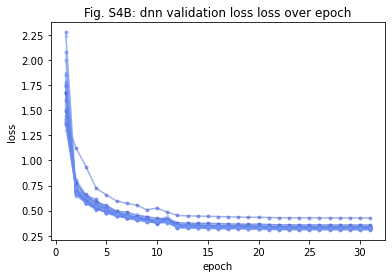

In [3]:
loss_dir = opj(DNN_DIR, 'checkpoint')

dnn_res_df = pd.concat([
    pd.read_csv(opj(loss_dir, f'{cur_model}.txt'), delimiter='\t', header=0).assign(model=cur_model)
    for cur_model in range(1, 31)
], ignore_index=True)


# Plot
colors = sns.color_palette('coolwarm', n_colors=53)
colors = colors[0:20] * 5

fig, ax = plt.subplots()
for idx, color in enumerate(dnn_res_df['model'].unique()):
    filtered_df = dnn_res_df[dnn_res_df['model'] == color]
    ax.plot(filtered_df['n'], filtered_df['loss'], 'o-', markersize=3, alpha=0.5, color=colors[idx])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Fig. S4B: dnn validation loss {} over epoch'.format('loss'))
#plt.savefig(opj(OUT_DIR, 'dnn_validation_loss.svg'), format="svg", dpi=300)
plt.show()

## 2. Correlation between model predicted values and the ground-truth values

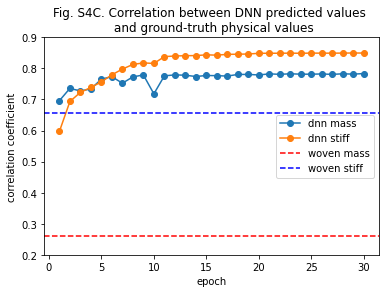

In [4]:
## Woven
woven_df = pd.read_csv(opj(DATA_DIR, 'wovenab', 'wovenab.csv'))
split_targets = woven_df['target'].str.split('_', expand=True)
woven_df['gt_mass'] = split_targets[1].astype(float)
woven_df['gt_stiff'] = split_targets[2].astype(float)

woven_stiff_cor = np.corrcoef(woven_df['gt_stiff'], woven_df['stiff'])[0][1]
woven_mass_cor = np.corrcoef(woven_df['gt_mass'], woven_df['mass'])[0][1]

## DNN
def get_cor(x):
    return [np.corrcoef(x['gt_stiff'], x['stiff'])[0][1], 
            np.corrcoef(x['gt_mass'], x['mass'])[0][1]
           ]

dnn_df = pd.concat([
    pd.read_csv(opj(DNN_DIR, f'dnn_{_epoch}.csv'), delimiter=',', header=0).assign(epoch=_epoch)
    for _epoch in range(1,31)
], ignore_index=True)

split_targets = dnn_df['target'].str.split('_', expand=True)
dnn_df['gt_mass'] = split_targets[1].astype(float)
dnn_df['gt_stiff'] = split_targets[2].astype(float)

dnn_df = dnn_df.groupby('epoch').apply(get_cor).reset_index()
dnn_df[['cor_gt-stiff', 'cor_gt-mass']] = pd.DataFrame(dnn_df[0].tolist(), index=dnn_df.index)
dnn_df = dnn_df.drop(columns=[0])


## Plot
plot_conds = ['mass', 'stiff']

for _plot_cond in plot_conds:
    plt.plot(dnn_df['epoch'], dnn_df[f'cor_gt-{_plot_cond}'], label=_plot_cond, marker='o')    

plt.ylim(0.2, 0.9)
plt.axhline(y=woven_mass_cor, color='r', linestyle='--', label='woven mass')
plt.axhline(y=woven_stiff_cor, color='b', linestyle='--', label='woven stiff')
plt.xlabel('epoch')
plt.ylabel('correlation coefficient')
plt.title('Fig. S4C. Correlation between DNN predicted values \n and ground-truth physical values')
labels = ['dnn mass', 'dnn stiff', 'woven mass', 'woven stiff']
plt.legend(labels=labels)
#plt.savefig(opj(OUT_DIR, 'dnn_cor_with_ground-truth.svg'), format="svg", dpi=300)
plt.show()

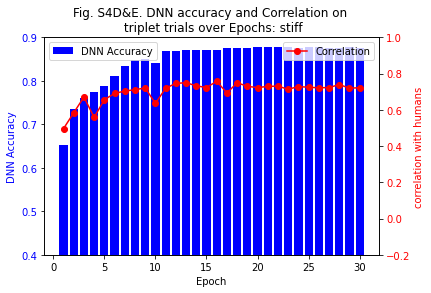

Task: stiff, best correlation at epoch=16


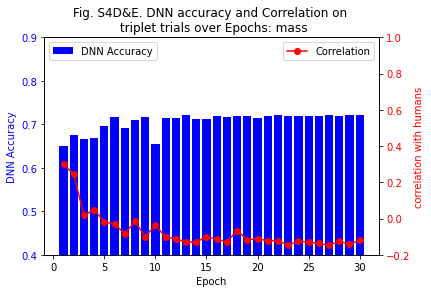

Task: mass, best correlation at epoch=1


In [5]:
conds = ['stiff', 'mass']
dnn_range = range(1,31)

for cond in conds:
    cor_over_epoch, acc_over_epoch = [], []
    for epoch in dnn_range:
        parsed_f = pd.read_csv(opj(DATA_DIR, 'parsed_questions_dnn_over_epoch', f'parsed_questions_{cond}_{epoch}.csv'))
        acc_over_epoch.append(np.mean(parsed_f['dnn_acc']))

        plot_data = parsed_f.groupby(['reldiff', 'ireldiff']).agg({
            'human_acc': 'mean',
            'dnn_acc': 'mean',
        }).reset_index()
        plot_data = plot_data.round(2)
        cor = np.corrcoef(plot_data['dnn_acc'], plot_data['human_acc'])[0][1]
        cor_over_epoch.append(cor)


    fig, ax1 = plt.subplots()
    ax1.bar(dnn_range, acc_over_epoch, color='b', label='DNN Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('DNN Accuracy', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(0.4, 0.9)  
    ax1.set_title(f'Fig. S4D&E. DNN accuracy and Correlation on \n triplet trials over Epochs: {cond}')

    ax2 = ax1.twinx()
    ax2.plot(dnn_range, cor_over_epoch, color='r', marker='o', linestyle='-', label='Correlation')
    ax2.set_ylabel('correlation with humans', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(-0.2, 1)  

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    #plt.savefig(opj(OUT_DIR, f'dnn_cor_tile_{cond}.svg'), format="svg", dpi=300)
    plt.show()
    
    print(f"Task: {cond}, best correlation at epoch={1+cor_over_epoch.index(max(cor_over_epoch))}")